In [1]:
using JuMP, Gurobi

function solveMaze(numWayPoints, numHoverCrafts, numObstacles, A, bo, inputWayPoints, avoidObstacles
    , avoidHoverCraftsCollision, lambda)
    
    m = Model(solver = GurobiSolver(OutputFlag=0))

    # Variable for resulting position for each hovercraft
    @variable(m, x[1:2,1:T[numWayPoints],1:numHoverCrafts])

    # Variable for resulting velocity for each hovercraft
    @variable(m, v[1:2,1:T[numWayPoints],1:numHoverCrafts])

    # Variable for thruster input for each hovercraft
    @variable(m, u[1:2,1:T[numWayPoints],1:numHoverCrafts])

    # Binary variables for logical constraints to be imposed to implement
    # static obstacle avoidance. This is a four dimensional variable where
    # first dimension: number of obstacles
    # second dimension: 1 each for x_min, x_max, y_min and y_max for an obstacle
    # third dimension: Number of time steps.
    # fourth dimension: Number of hovercrafts
    @variable(m, obstacle[1:numObstacles,1:4,1:T[numWayPoints],1:numHoverCrafts], Bin)

    # Binary variables for logical constraints to be imposed to implement
    # collision avoidance between hovercrafts. This is a four dimensional variable where
    # first dimension: 1 each for x_min, x_max, y_min and y_max for an obstacle
    # second dimension: Number of time steps.
    # third dimension: Number of hovercrafts.
    # fourth dimension: Number of hovercrafts.
    @variable(m, obstacleS[1:4,1:T[numWayPoints],1:numHoverCrafts,1:numHoverCrafts], Bin)
    
    vMax = 1
    
    # satisfy the dynamics (with zero initial velocity)
    @constraint(m, v[:,1,:] .== [0;0])

    # Simple linear model of hovercraft dynamics imposed on each timestep.
    # Change in resulting position should be equal to the velocity at that instant.
    # Change in resulting velocity should be equal to the thruster input at that instant.
    for t in 1:T[numWayPoints]-1
        @constraint(m, x[:,t+1,:] .== x[:,t,:] + v[:,t,:])
        @constraint(m, v[:,t+1,:] .== v[:,t,:] + u[:,t,:])
    end

    # Constraint on each hovercraft for each time step to be in the maximum velocity
    # limit.
    for n in 1:numHoverCrafts
        for t in 1:T[numWayPoints]
            @constraint(m, sum(v[:,t,n].^2) <= vMax)
        end
    end
    
    # hit all the waypoints
    for n in 1:numHoverCrafts
        for t in [1 numWayPoints]
            @constraint(m, x[:,T[t],n] .== inputWayPoints[:,t,n])
        end
    end

    # Avoid all obstacles
    if avoidObstacles
        for n in 1:numHoverCrafts
            for o in 1:numObstacles
                for t in 1:T[numWayPoints]-1
                    @constraint(m, A*x[:,t,n] .<= bo[:,o] .+ 1000*obstacle[o,:,t,n])
                    # Constraint to relax no more than three constraints on the resulting position
                    # of each hovercraft. This ensures that all hovercrafts stay out of the bounding
                    # box of each obstacle.
                    @constraint(m, sum(obstacle[o,i,t,n] for i in 1:4) <= 3)
                end
            end
        end
    end
                
    if avoidHoverCraftsCollision
        for n1 in 1:numHoverCrafts-1
            for n2 in n1+1:numHoverCrafts
                for t in 3:T[numWayPoints]-3
                    @constraint(m, x[1,t,n1] <= x[1,t,n2] - .5 + 1000*obstacleS[1,t,n1,n2])
                    @constraint(m, -x[1,t,n1] <= -(x[1,t,n2] + .5) + 1000*obstacleS[2,t,n1,n2])
                    @constraint(m, x[2,t,n1] <= x[2,t,n2] - .5 + 1000*obstacleS[3,t,n1,n2])
                    @constraint(m, -x[2,t,n1] <= -(x[2,t,n2] + .5) + 1000*obstacleS[4,t,n1,n2])
                    @constraint(m, sum(obstacleS[i,t,n1,n2] for i in 1:4) <= 3)
                end
            end
        end
    end

    # minimize 2-norm (THIS IS LEAST-SQUARES)
    @objective(m, Min, sum(u.^2) + lambda*sum(sum((x[:,T[2:numWayPoints],n]-inputWayPoints[:,2:numWayPoints,n]).^2 for n in 1:numHoverCrafts)))
    @time solve(m)
    xopt=getvalue(x)
    return xopt, getvalue(u), getobjectivevalue(m), getvalue(sum(u.^2)), getvalue(sum(sum((x[:,T[2:numWayPoints],n]-inputWayPoints[:,2:numWayPoints,n]).^2 for n in 1:numHoverCrafts)))
end
;

In [2]:
using PyPlot

function plotMazeSolution(xopt, numWayPoints, numHoverCrafts, numObstacles, A, bo, inputWayPoints, xo)
    figure(figsize=(12,4))
    for n in 1:numHoverCrafts
        plot( xopt[1,:,n][:], xopt[2,:,n][:],".-", markersize=4 )
        plot( xopt[1,1:5:T[numWayPoints],n][:], xopt[2,1:5:T[numWayPoints],n][:],"k.", markersize=4 )
    end

    for n in 1:numHoverCrafts
        plot(inputWayPoints[1,:,n], inputWayPoints[2,:,n], "r.", markersize=12 )
    end

    for o in 1:numObstacles
        # lower and upper lines
        plot(linspace(xo[1,o] - bbo[1,o],xo[1,o] + bbo[1,o],10),
            0.*linspace(xo[1,o] - bbo[1,o],xo[1,o] + bbo[1,o],10) .+ (xo[2,o] - bbo[2,o]))
        plot(linspace(xo[1,o] - bbo[1,o],xo[1,o] + bbo[1,o],10),
            0.*linspace(xo[1,o] - bbo[1,o],xo[1,o] + bbo[1,o],10) .+ (xo[2,o] + bbo[2,o]))

        # left and right lines
        plot(0.*linspace(xo[2,o] - bbo[2,o],xo[2,o] + bbo[2,o],10) .+ (xo[1,o] - bbo[1,o]),
            linspace(xo[2,o] - bbo[2,o],xo[2,o] + bbo[2,o],10))
        plot(0.*linspace(xo[2,o] - bbo[2,o],xo[2,o] + bbo[2,o],10) .+ (xo[1,o] + bbo[1,o]),
            linspace(xo[2,o] - bbo[2,o],xo[2,o] + bbo[2,o],10))
    end
    axis("equal");
end
;

In [8]:
# number of waypoints
numWayPoints = 3

# number of obstacles
numObstacles = 2

# number of hovercrafts
numHoverCrafts = 2             

# vector of timepoints
T = zeros(Int,numWayPoints)

# vector of waypoint locations, (x,y) locations of each waypoint
inputWayPoints = zeros(2, numWayPoints, numHoverCrafts)

# vector of obstacle locations, (x,y) locations of each obstacle
inputObstacles = zeros(2, numObstacles)

# bounding box around obstacle, (breadth, length) of the obstacle.
# Breadth is added and subtracted from the x dimension of the location of the obstacle to
# get upper and lower limits of obstacle respectivly.
# Similalry for length.
bbo = zeros(2, numObstacles)

# Maximum velocity at which the hovercraft can travel.
vMax = 1

# Time instant at which the hovercraft should the waypoint
T[1] = 1
T[2] = 20
T[3] = 40


# define waypoints
inputWayPoints[:,:,1] = [0 10 25
                        15 20 15]

inputWayPoints[:,:,2] = [0 10 25
                        15 20 15]

# define obstacles
inputObstacles = [ 5 15
                   18 20]
    
# define bounding box limits of the obstacles
bbo = [ 1   1
        1.2 1.5 ]

# Matrix to write vectorized constraints for avoiding static obstacles
A = [1 0;
    -1 0;
    0 1;
    0 -1;]

# Matrix to store upper and lower limits of the vectorized constraints
bo = zeros(4, numObstacles)

# This loop constructs b for the vectorized constraints Ax - b <= obstacles
for i in 1:numObstacles
    bo[1,i] = inputObstacles[1,i] - bbo[1,i]
    bo[2,i] = -(inputObstacles[1,i] + bbo[1,i])
    bo[3,i] = inputObstacles[2,i] - bbo[2,i]
    bo[4,i] = -(inputObstacles[2,i] + bbo[2,i])
end

lambda = 100/1000
;

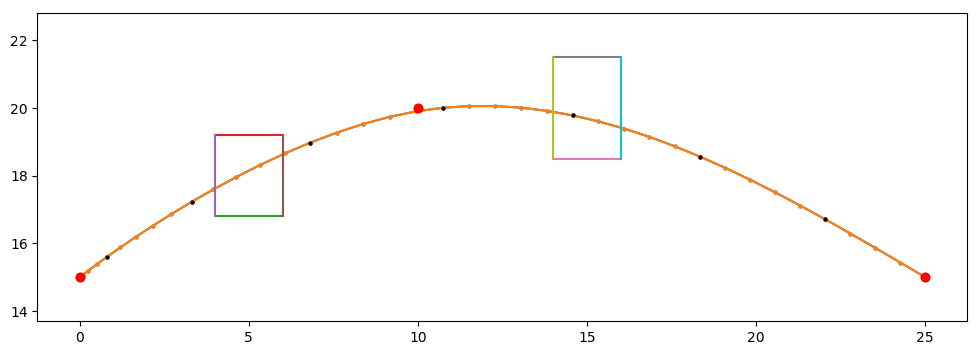

  0.139704 seconds (1.18 k allocations: 383.078 KB)


In [9]:
lambda = 0.1
xopt_none, uopt_none, objectivevalue_none, J1, J2 = solveMaze(numWayPoints, numHoverCrafts, numObstacles, A, bo, inputWayPoints, false, false, lambda)
plotMazeSolution(xopt_none, numWayPoints, numHoverCrafts, numObstacles, A, bo, inputWayPoints, inputObstacles)
;

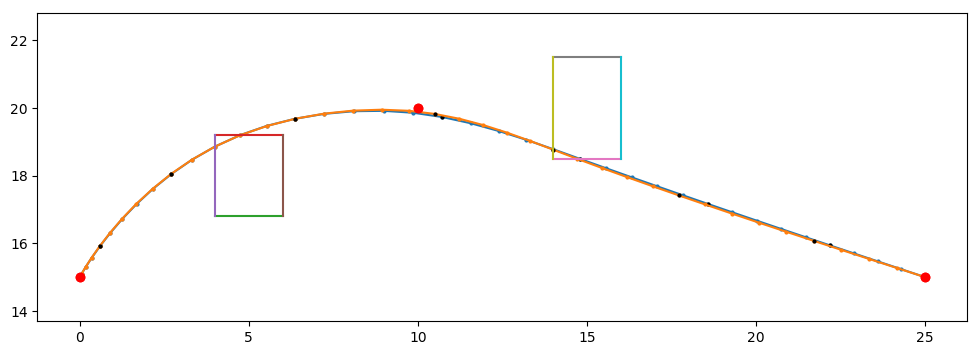

  3.212797 seconds (1.20 k allocations: 668.375 KB)


In [10]:
lambda = 0.1
xopt, uopt, objectivevalue, J1, J2 = solveMaze(numWayPoints, numHoverCrafts, numObstacles, A, bo, inputWayPoints, true, false, lambda)
plotMazeSolution(xopt, numWayPoints, numHoverCrafts, numObstacles, A, bo, inputWayPoints, inputObstacles)
;

  2.931509 seconds (1.20 k allocations: 732.125 KB)
  1.999150 seconds (1.20 k allocations: 732.125 KB)
  0.739613 seconds (1.20 k allocations: 732.125 KB)
  0.895807 seconds (1.20 k allocations: 732.125 KB)
  1.243345 seconds (1.20 k allocations: 732.125 KB)
  0.785444 seconds (1.20 k allocations: 732.125 KB)
  1.094618 seconds (1.20 k allocations: 732.125 KB)
  3.310224 seconds (1.20 k allocations: 732.125 KB)
  2.563787 seconds (1.20 k allocations: 732.125 KB)
  5.268261 seconds (1.20 k allocations: 732.125 KB)
 10.042123 seconds (1.20 k allocations: 732.125 KB)
  4.280005 seconds (1.20 k allocations: 732.125 KB)
 22.397619 seconds (1.20 k allocations: 732.125 KB)
  7.056958 seconds (1.20 k allocations: 732.125 KB)
  9.955475 seconds (1.20 k allocations: 732.125 KB)
  4.085197 seconds (1.20 k allocations: 732.125 KB)
  7.529715 seconds (1.20 k allocations: 732.125 KB)
  3.359598 seconds (1.20 k allocations: 732.125 KB)
  1.882760 seconds (1.20 k allocations: 732.125 KB)
  2.145805 s

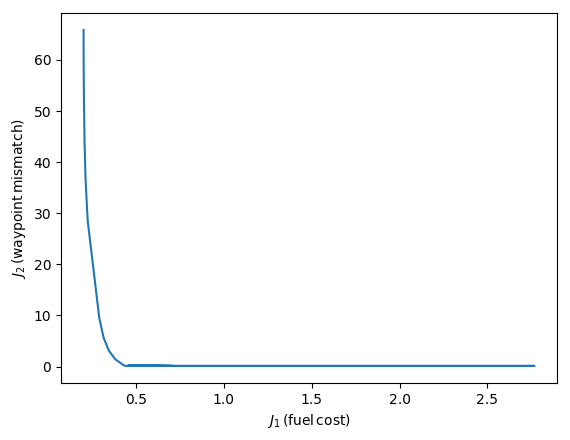

  2.569317 seconds (1.20 k allocations: 732.125 KB)


In [6]:
Npts = 25
J1 = zeros(Npts)
J2 = zeros(Npts)

i = 1
lambda = 0.1
for (i,lambda) in enumerate(logspace(-5,2,Npts))
    xopt, uopt, objectivevalue, J1[i], J2[i] = solveMaze(numWayPoints, numHoverCrafts, numObstacles, A, bo, inputWayPoints, true, true, lambda)
end

figure()
plot(J1, J2)
xlabel(L"J_1\, (\sf fuel\, cost)");
ylabel(L"J_2\, (\sf waypoint\, mismatch)")
;

  3.425534 seconds (1.20 k allocations: 732.125 KB)


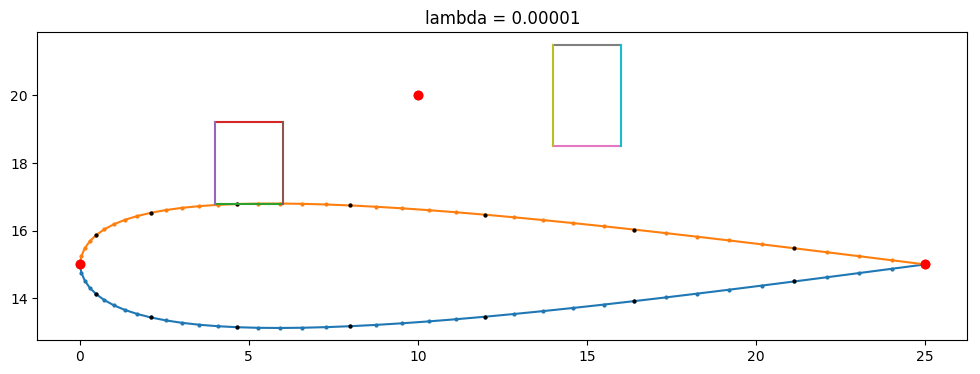

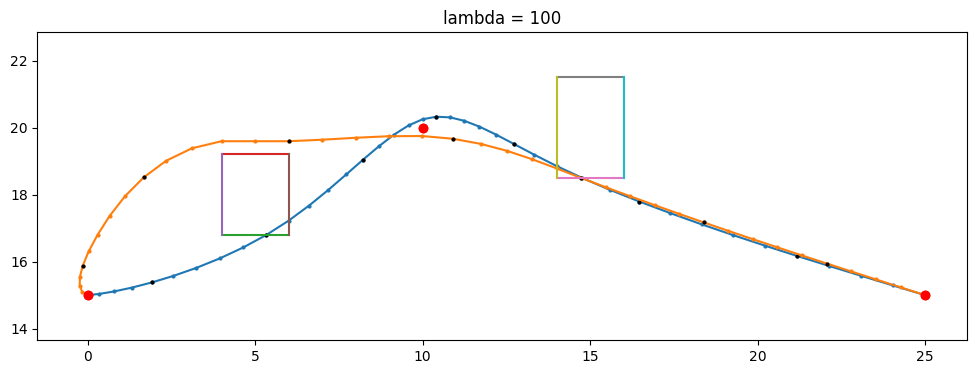

  1.072977 seconds (1.20 k allocations: 732.125 KB)


In [11]:
lambda = 1/100000
xopt, uopt, objectivevalue, j1, j2 = solveMaze(numWayPoints, numHoverCrafts, numObstacles, A, bo, inputWayPoints, true, true, lambda)
plotMazeSolution(xopt, numWayPoints, numHoverCrafts, numObstacles, A, bo, inputWayPoints, inputObstacles)
title("lambda = 0.00001")


figure()
lambda = 100
xopt, uopt, objectivevalue, j1, j2 = solveMaze(numWayPoints, numHoverCrafts, numObstacles, A, bo, inputWayPoints, true, true, lambda)
plotMazeSolution(xopt, numWayPoints, numHoverCrafts, numObstacles, A, bo, inputWayPoints, inputObstacles)
title("lambda = 100")
;